# Matplotlib Demo with CMS MA Cutpoint Data

Notes
* Demo of figure-axes concepts
* Demo of single plot, explicitly creating subplots (axes), and dynamically creating subplots (axes)
* Takeaways
    * We have 2 APIs for matplotlib: OOP and PyPlot/MATLAB-ish
    * Suggested pattern: if you use pandas, start with dataframe.plot() and customize using fig/ax pattern from there 

Further reading:
* https://pbpython.com/effective-matplotlib.html
    * This tutorial ended up being incorporated into official docs here:
    * https://matplotlib.org/3.2.1/tutorials/introductory/lifecycle.html#sphx-glr-tutorials-introductory-lifecycle-py
* https://ryxcommar.com/2020/04/11/why-you-hate-matplotlib/
* https://medium.com/@rayheberer/generating-matplotlib-subplots-programmatically-cc234629b648
* https://seaborn.pydata.org/tutorial.html

# Introducing terminology/API jargon

### Anatomy of a figure

Source: https://matplotlib.org/3.2.1/tutorials/introductory/lifecycle.html#sphx-glr-tutorials-introductory-lifecycle-py
![image.png](https://matplotlib.org/3.2.1/_images/anatomy.png)

### Modifying a figures and axes object
Source: https://pbpython.com/effective-matplotlib.html
![image.png](https://pbpython.com/images/matplotlib-pbpython-example-header.png)

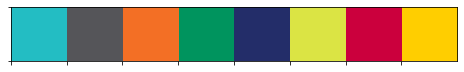

In [1]:
import os
import re

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns
import xlwings as xw

# set corporate color theme with hex values
custom_palette = ['#23BDC3', #turquoise, primary
               '#555559', #gray
               '#F36F25', #orange
               '#00945E', #green
               '#232D69', #blue, primary
               '#DBE444', #lime
               '#CB003D', #red
               '#FFCE00'] #yellow

sns.set_palette(custom_palette)
sns.palplot(custom_palette)

### Data Prep

In [2]:
# pre-processed data source
# https://www.cms.gov/Medicare/Prescription-Drug-Coverage/PrescriptionDrugCovGenIn/PerformanceData

# get data
file_path_url = 'https://raw.githubusercontent.com/paulzuradzki/mpl-plot-demo-cms-cutpoints/master/cms_cutpoints_historical.csv'
df = pd.read_csv(file_path_url)

In [3]:
df.head()

,contract_year,category,measure_name,measure_period,1 Star,2 Stars,3 Stars,4 Stars,5 Stars
0,2020,"HD1: Staying Healthy: Screenings, Tests and Va...",C01: Breast Cancer Screening,01/01/2018 – 12/31/2018,< 50%,? 50% to < 66%,? 66% to < 76%,? 76% to < 83%,? 83%
1,2020,"HD1: Staying Healthy: Screenings, Tests and Va...",C02: Colorectal Cancer Screening,01/01/2018 – 12/31/2018,< 43%,? 43% to < 62%,? 62% to < 73%,? 73% to < 80%,? 80%
2,2020,"HD1: Staying Healthy: Screenings, Tests and Va...",C03: Annual Flu Vaccine,03/2019 – 05/2019,< 66,? 66 to < 70,? 70 to < 76,? 76 to < 79,? 79
3,2020,"HD1: Staying Healthy: Screenings, Tests and Va...",C04: Improving or Maintaining Physical Health,04/01/2018 – 07/31/2018,< 66%,? 66% to < 68%,? 68% to < 70%,? 70% to < 72%,? 72%
4,2020,"HD1: Staying Healthy: Screenings, Tests and Va...",C05: Improving or Maintaining Mental Health,04/01/2018 – 07/31/2018,< 72%,? 72% to < 78%,? 78% to < 82%,? 82% to < 84%,? 84%


In [4]:
# regex searches for: decimal followed by 3 numbers or 2 numbers
rx = re.compile(r'(\.?\d\d\d|\d\d)')

def regex_strip_cut_pts(row_val: str):
    '''Regex to strip symbols out of cut points.
    
    Example
    -------
    >>> regex_strip_cut_pts('? 43% to < 62%')
    43.0
    >>> regex_strip_cut_pts('< 43%')
    43.0
    >>> regex_strip_cut_pts('0.203 to < 0.000')
    0.203
    '''
    try: 
        transformed = rx.search(row_val).groups()[0]
        return float(transformed)
    except:
        return None

# apply regex to cutpoints
stars = ['2 Stars', '3 Stars', '4 Stars', '5 Stars']
df[stars] = df[stars].applymap(regex_strip_cut_pts)

# don't need 1 star
df = df.drop(columns='1 Star')

# parse measure ID and name to different columns, ex: 'C03: Annual Flu Vaccine'
df['measure_name_orig'] = df['measure_name']
df['measure_id'] = df['measure_name'].str.split(': ', expand=True)[0]
df['measure_name'] = df['measure_name'].str.split(': ', expand=True)[1]

# quick fix year to str to get rid of decimal (ex: 2020.0)
df['contract_year'] = df['contract_year'].astype(int).astype(str)

# sort so years appear in order
df = df.sort_values(by=['measure_name_orig', 'contract_year'])

# we'll use unique list of measure names for our plot grouping variable
measure_names = df['measure_name'].drop_duplicates().tolist()

In [5]:
# inspect modified columns: measure_id, measure_name, 2-5 Stars
df.head()

,contract_year,category,measure_name,measure_period,2 Stars,3 Stars,4 Stars,5 Stars,measure_name_orig,measure_id
129,2016,"HD1: Staying Healthy: Screenings, Tests and Va...",Breast Cancer Screening,01/01/2014 - 12/31/2014,39.0,63.0,74.0,80.0,C01: Breast Cancer Screening,C01
97,2017,"HD1: Staying Healthy: Screenings, Tests and Va...",Breast Cancer Screening,01/01/2015 - 12/31/2015,43.0,63.0,69.0,76.0,C01: Breast Cancer Screening,C01
65,2018,"HD1: Staying Healthy: Screenings, Tests and Va...",Breast Cancer Screening,01/01/2016 – 12/31/2016,56.0,70.0,78.0,84.0,C01: Breast Cancer Screening,C01
31,2019,"HD1: Staying Healthy: Screenings, Tests and Va...",Breast Cancer Screening,01/01/2017 – 12/31/2017,47.0,68.0,76.0,82.0,C01: Breast Cancer Screening,C01
0,2020,"HD1: Staying Healthy: Screenings, Tests and Va...",Breast Cancer Screening,01/01/2018 – 12/31/2018,50.0,66.0,76.0,83.0,C01: Breast Cancer Screening,C01


# Plot Demos

### Single Plot

In [6]:
# test multiplot on single group
# subset dataframe to 1 group
measure_name = 'Adult BMI Assessment'
sub_df = df[df['measure_name'] == measure_name].copy()
stars_list = ['2 Stars', '3 Stars', '4 Stars', '5 Stars']
sub_df = sub_df[['measure_name', 'contract_year']+stars_list]
sub_df

,measure_name,contract_year,2 Stars,3 Stars,4 Stars,5 Stars
135,Adult BMI Assessment,2016,70.0,81.0,90.0,96.0
103,Adult BMI Assessment,2017,45.0,63.0,87.0,96.0
71,Adult BMI Assessment,2018,72.0,81.0,94.0,98.0
37,Adult BMI Assessment,2019,76.0,84.0,93.0,98.0
6,Adult BMI Assessment,2020,78.0,92.0,96.0,99.0


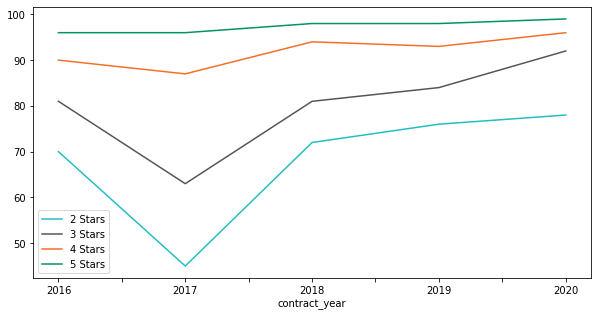

In [7]:
# manage single axis on figure
fig, ax = plt.subplots(figsize=(10, 5))

# pandas df.plot() style
sub_df.plot(x='contract_year', y=stars_list, kind='line', ax=ax)

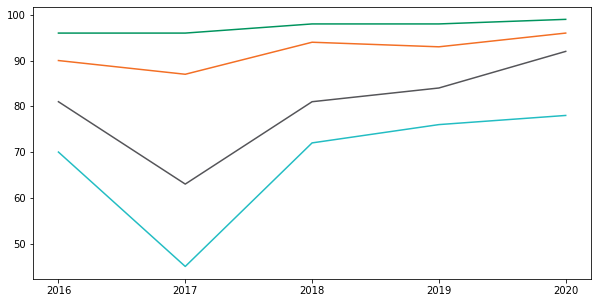

In [8]:
# Alternative ax.plot() style 
# * feeding array-like objects as opposed to field names
# * note: matplotlib is designed for numpy ndarrays

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sub_df['contract_year'], sub_df[stars].values)

### Formatting the axes and figure objects

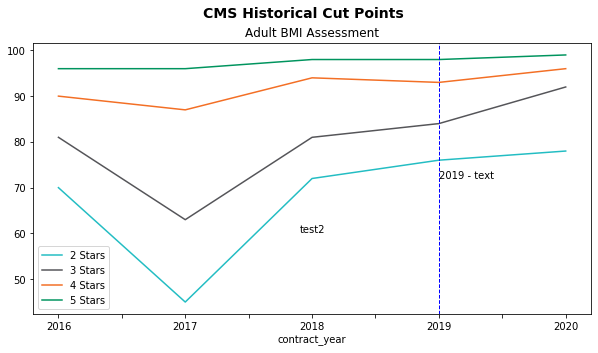

In [9]:
# manage single axis on figure
fig, ax = plt.subplots(figsize=(10, 5))
sub_df.plot(x='contract_year', y=stars, kind='line', ax=ax)


ax.set(title=sub_df['measure_name'].iloc[0])
ax.legend().set_visible(True)
fig.suptitle('CMS Historical Cut Points', fontsize=14, fontweight='bold')

#annotations
ax.text(3, 72, '2019 - text') # (x,y,label)
ax.annotate('test2', # this is the text
         (2,60), # this is the point to label
         textcoords="offset points", # how to position the text
         xytext=(0,1), # distance from text to points (x,y)
         ha='center') # horizontal alignment can be left, right or center

ax.axvline(x=3, color='b', label='2019', linestyle='--', linewidth=1)

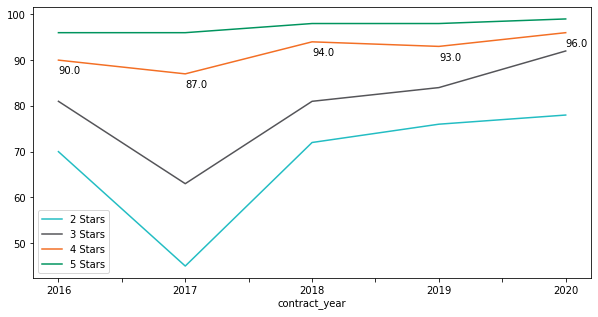

In [10]:
# adding many data labels
# X values are based on position 1-5
# since 'contract_year', in this event, is an 'object'/string data type

fig, ax = plt.subplots(figsize=(10, 5))
sub_df.plot(x='contract_year', y=stars, kind='line', ax=ax)

xs = np.arange(5)
# xs = np.arange(sub_df['contract_year'].nunique())

ys = sub_df['4 Stars']

for x,y in zip(xs,ys):
    ax.text(x,y-3,y)

### Explicitly configuring subplots

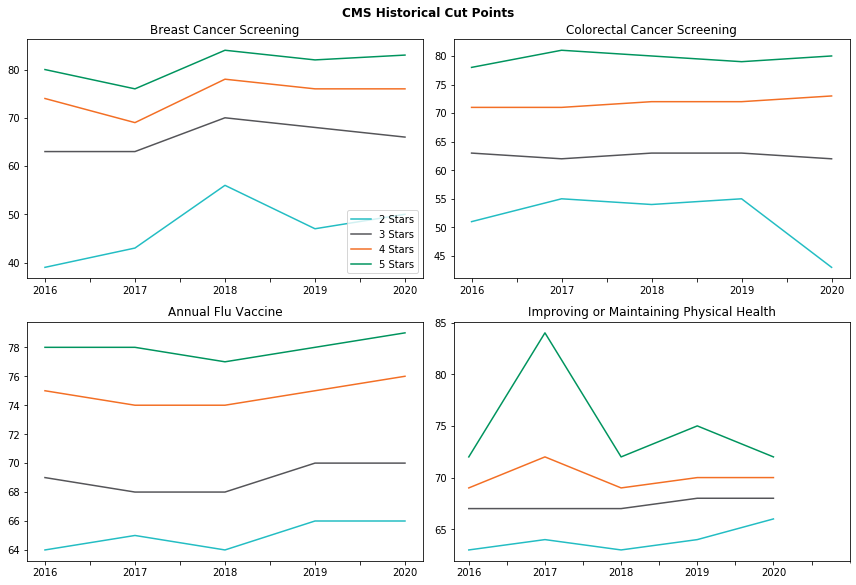

In [11]:
# demo by explicitly creating axes objects (ax0-ax4)
# pros: customization at plot-level, cons: repetitive code

fig, ((ax0, ax1), (ax2, ax3))  = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
# fig, axes  = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

four_measures = ['Breast Cancer Screening', 'Colorectal Cancer Screening', 
                 'Annual Flu Vaccine', 'Improving or Maintaining Physical Health']

measure_name = four_measures[0]
sub_df0 = df[df['measure_name'] == measure_name].copy()
sub_df0.plot(x='contract_year', y=stars, kind='line', ax=ax0)
ax0.set(title=measure_name, xlabel=None)
ax0.legend().set_visible(True)
ax0.legend(loc='lower right')

measure_name = four_measures[1]
sub_df1 = df[df['measure_name'] == measure_name].copy()
sub_df1.plot(x='contract_year', y=stars, kind='line', ax=ax1)
ax1.set(title=measure_name, xlabel=None)
ax1.legend().set_visible(False)
      
measure_name = four_measures[2]
sub_df2 = df[df['measure_name'] == measure_name].copy()
sub_df2.plot(x='contract_year', y=stars, kind='line', ax=ax2)
ax2.set(title=measure_name, xlabel=None)
ax2.legend().set_visible(False)

measure_name = four_measures[3]
sub_df3 = df[df['measure_name'] == measure_name].copy()
sub_df3.plot(x='contract_year', y=stars, kind='line', ax=ax3)
ax3.set(title=measure_name, xlabel=None)
ax3.legend().set_visible(False)
ax3.set_xticks(ticks=np.arange(6), minor=True)

fig.suptitle('CMS Historical Cut Points', fontsize=12, fontweight='bold', y=1.01)
plt.tight_layout()

### Dynamic - iterating through subplots

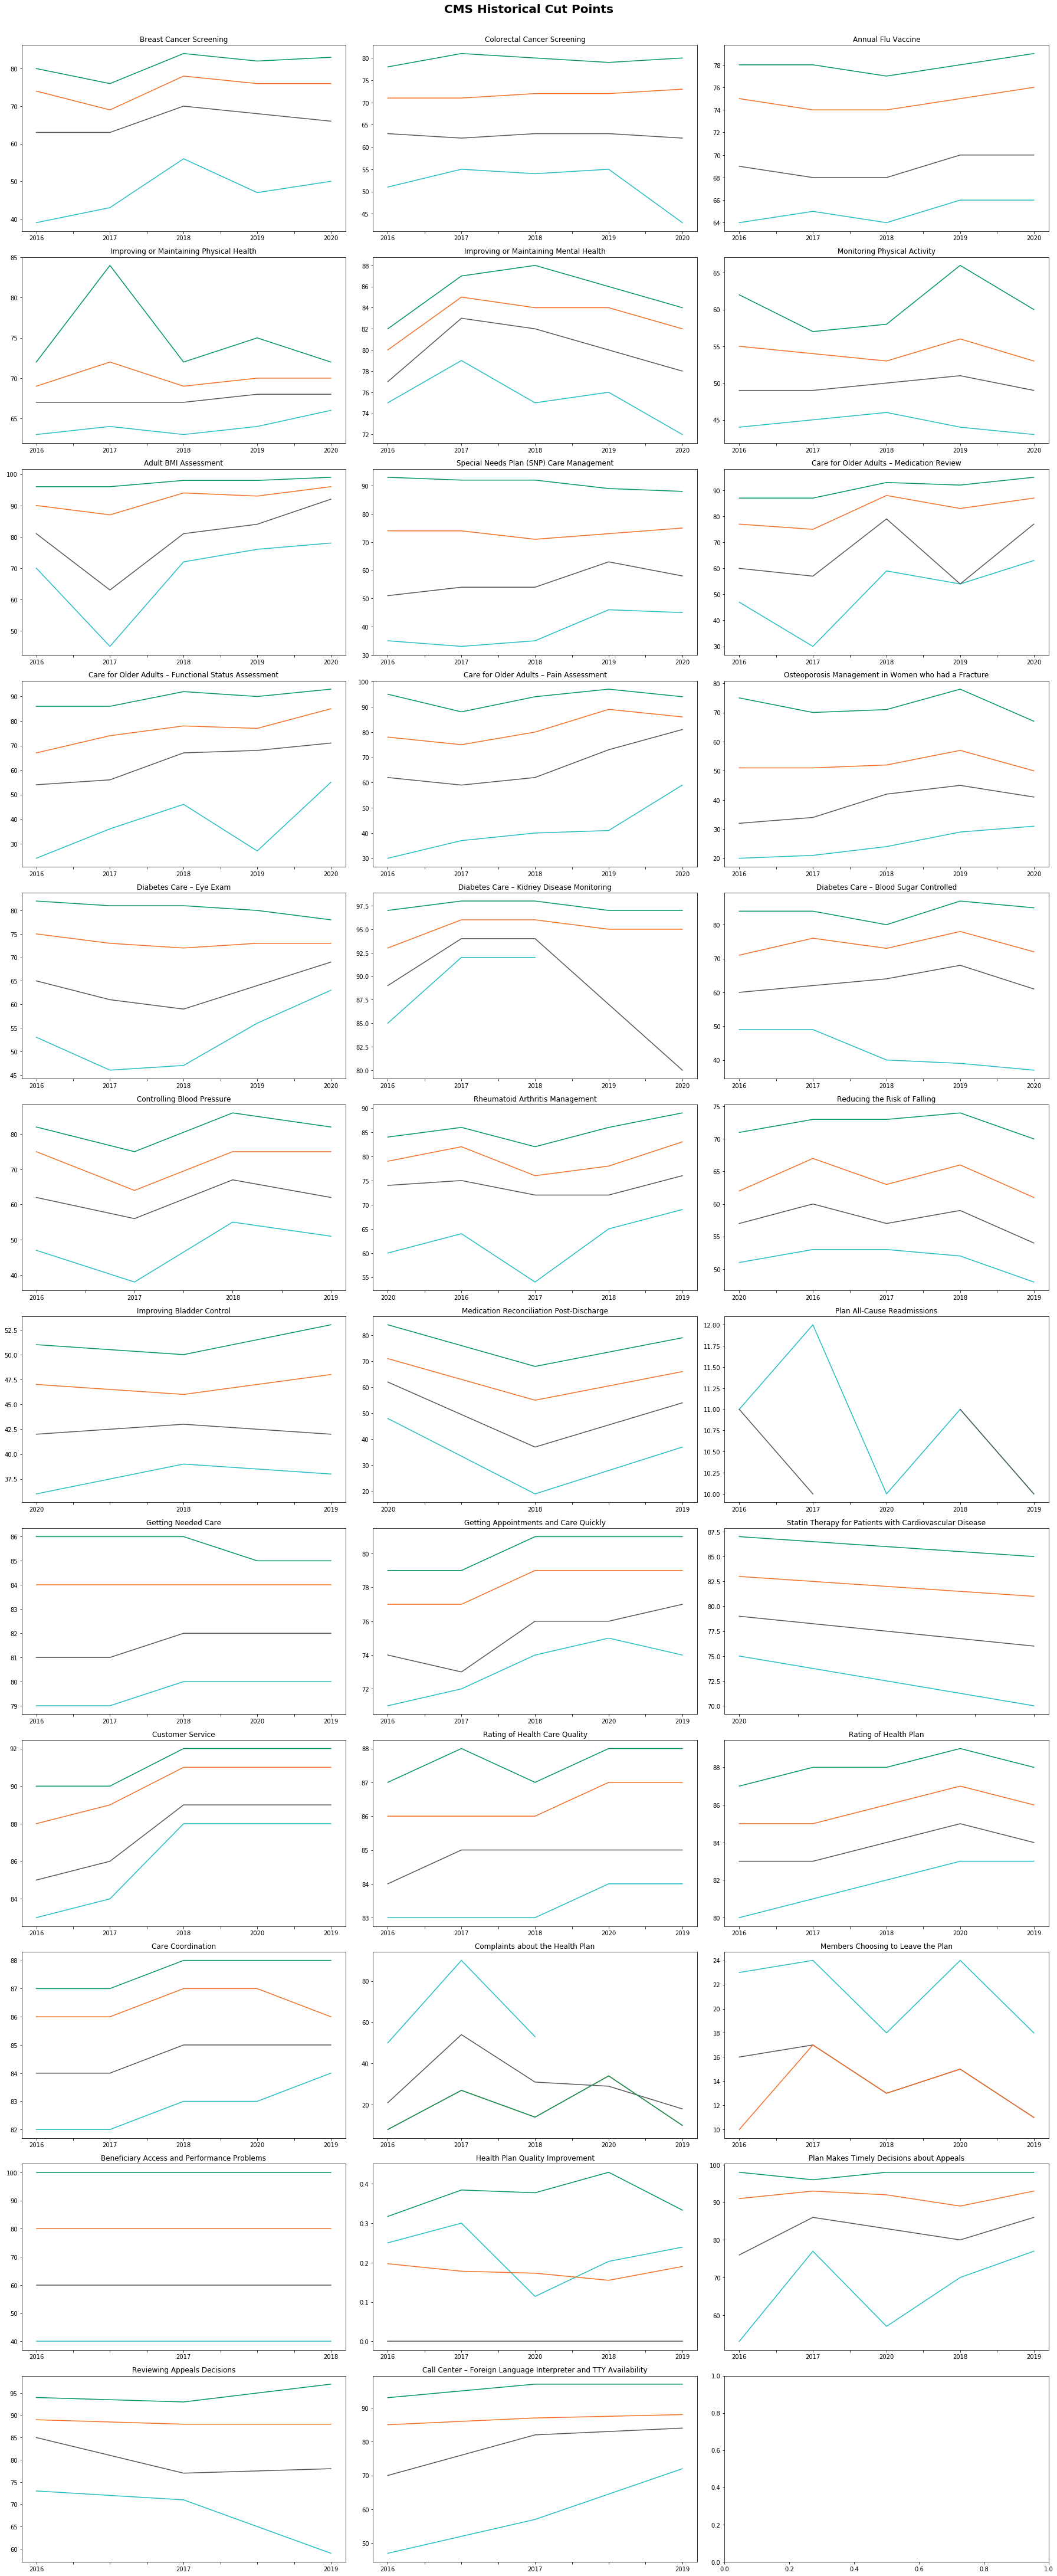

In [12]:
# here we dynamically generate axes objects
# notice, we don't explicitly call ax1.plot(), ax2.plot(), etc.
# nor, df.plot(ax=ax1), df.plot(ax=ax2), etc.

# axes is of type np.ndarray shaped as (nrows, ncols) of total # of axes objects (# plots)
fig, axes = plt.subplots(nrows=12, ncols=3, figsize=(25,60))

# to loop through the axes, we need to flatten the list into 1-D array
# we use zip, because we want to also loop through equal-sized, ordered, and related collections
    # for things like getting the measure_name into the title or subsetting the dataframe
for ax, measure_name in zip(axes.flatten(), measure_names):
    sub = df[df['measure_name'] == measure_name].copy()
    sub.plot(x='contract_year', y=stars, kind='line', ax=ax)
    ax.set(title=measure_name, xlabel=None)
    ax.legend().set_visible(False)
    
fig.suptitle('CMS Historical Cut Points', fontsize=20, fontweight='bold', y=1.01)
plt.tight_layout()

### Exploring the axes ndarray object

In [13]:
type(axes)

numpy.ndarray

In [14]:
axes[0]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CBCE36D248>,
      dtype=object)

In [ ]:
# mpl supports a variety of "backends" like jpeg, png, pdf. See docs for more.
# fig.savefig('cut_points.pdf', transparent=False, dpi=80, bbox_inches='tight')